# Importerer nødvendige funksjoner 

(og plottoppsett) 

In [1]:
%matplotlib notebook
import geopandas as gpd
import matplotlib.pyplot as plt
import mplleaflet

D:\ProgramData\Anaconda3\envs\geomatikkdagene18\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


_Det viser seg at mplleaflet bruker en gammal versjon av matplotlib, som igjen bruker utdaterte metoder mot ipython kernel. Funker helt greit, men får advarsel. Greit nok for denne demoen sitt formål, men viser at ting utvikles fort, og dine favorittverktøy går fort ut på dato_

# Leser bryggeridata

In [2]:
#funksjoner for å fikse opp dataene

#oversett alt annet enn punkt til punkt
def to_point(row):
    if row['geometry'].geom_type == 'Point':
        return row['geometry']
    return row['geometry'].centroid

#set operator-taggen
def fix_operator(row):
    if row['operator'] is None:
        return row['name']
    return row['operator']

In [3]:
# les inn bryggeriene fra en geojson-fil
bryggerier = gpd.read_file('./data/osm_breweries_norway_08032018.geojson')

#fiks opp kolonner
bryggerier['geometry'] = bryggerier.apply(to_point, axis=1)
bryggerier['operator'] = bryggerier.apply(fix_operator, axis=1)

# print( bryggerier.columns)

# velg ut de kolonnene vi faktisk bruker
bryggerier = bryggerier[['name', 'operator', 'amenity', 'geometry']]

# Reprojiser til UTM33 
bryggerier = bryggerier.to_crs( { 'init' : 'epsg:32633' } )

# Leser sentrumsområder fra SSB 

In [4]:
sentrumsomr = gpd.read_file( './data/sentrum2017_web.shp')
# sentrumsomr.columns
sentrumsomr = sentrumsomr[['KOMMUNENR', 'KommunNavn', 'TETTSTEDSN', 'hoveds', 'geometry' ]]

# Hvem er super-urbanist-bryggeri? 

Spatial join mellom sentrumsområder og bryggerier. 

In [5]:
bryggerier_isentrum = gpd.sjoin( bryggerier, sentrumsomr, how='inner', op='intersects')
print( len( bryggerier_isentrum), 'av', len(bryggerier), 'bryggerier er super-urbanistbryggerier')

bryggerier_utenomsentrum = bryggerier.iloc[ ~bryggerier.index.isin( bryggerier_isentrum.index)]

40 av 138 bryggerier er super-urbanistbryggerier


Og bøgda-bryggerier er jo det inverse av sentrumsbryggeri-utvalget

In [7]:
bryggerier_utenomsentrum = bryggerier.iloc[ ~bryggerier.index.isin( bryggerier_isentrum.index)].copy()

Sentrumsområdene med bryggerier: 

In [8]:
sentrum_mbryggeri = sentrumsomr.iloc[ sentrumsomr.index.isin( bryggerier_isentrum.index_right ) ]

# Avstand fra bøgdabryggeri - nærmeste sentrum. 

In [48]:
def min_distance(fra, til):
    return til.distance(fra).min()

In [83]:
bryggerier_utenomsentrum['avst_sentrum'] = bryggerier_utenomsentrum.geometry.apply( min_distance, args=(sentrumsomr, ) )

In [90]:
bryggerier_utenomsentrum.avst_sentrum.describe()

count       98.000000
mean      9933.607066
std      12159.282643
min          5.769286
25%        751.042528
50%       4718.407354
75%      14146.988654
max      57094.019264
Name: avst_sentrum, dtype: float64

<IPython.core.display.Javascript object>


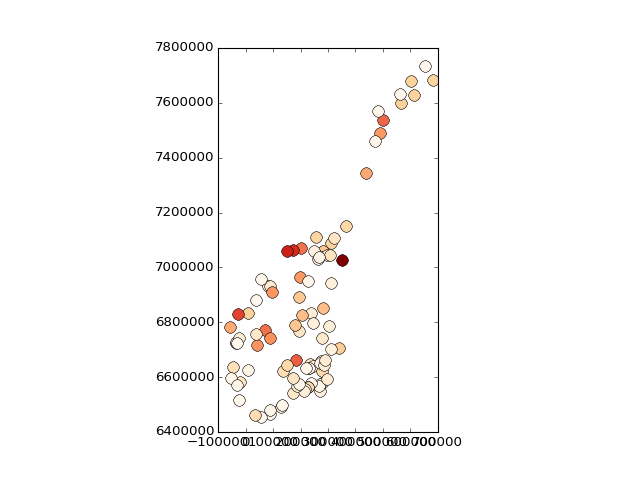

In [88]:
fig2, ax2 = plt.subplots()
ax2.set_aspect('equal')
bryggerier_utenomsentrum.plot( ax=ax2, 
                              column='avst_sentrum', 
                              markersize=10, 
                              cmap='OrRd') 

In [89]:
mplleaflet.show( fig=fig2, crs=crs_out)

# Litt plotting

Plotteksemplet blir litt stort som mplleaflet-kart (42 mb). Bør avgrenses, f.eks. med spatial Join på en BoundingBox eller noe slikt? 

<IPython.core.display.Javascript object>


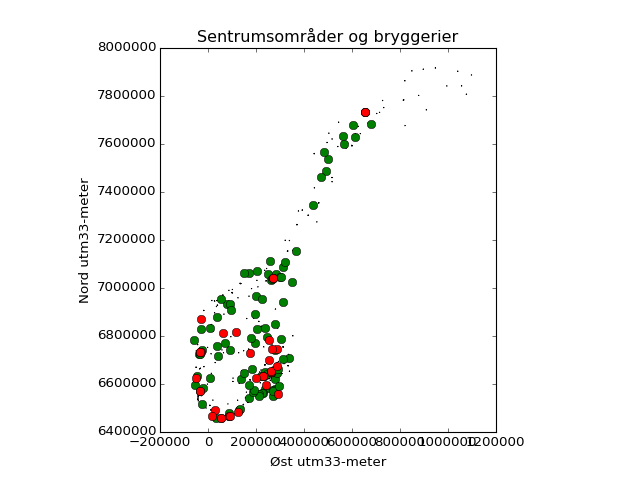

In [35]:
fig1, ax1 = plt.subplots()

# vistettsted = 'Stavanger'
vistettsted = 'Trondheim'
# ax1.set_title( 'Sentrumsområder, ' + vistettsted)
ax1.set_title( 'Sentrumsområder og bryggerier')
ax1.set_ylabel( 'Nord utm33-meter')
ax1.set_xlabel( 'Øst utm33-meter')
ax1.set_aspect('equal')

sentrum_mbryggeri.plot( ax=ax1, color = 'y') 
# sentrumsomr.iloc[ ~sentrumsomr.index.isin( bryggerier_isentrum.index_right ) ].plot( ax=ax1, color='b')

bryggerier_utenomsentrum.plot( ax = ax1, color = 'g', markersize = 8 )
bryggerier_isentrum.plot( ax = ax1, color = 'r', markersize = 8 )


In [6]:
crs_out = {'init': 'epsg:25833'}

mplleaflet.display( fig1,  crs=crs_out) 
# Blir for stort, får advarsel om IOPub data rate exceeded ... 
# bør avgrense datasettet før plotting. 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [36]:
mplleaflet.show( fig1, crs=crs_out) # Denna funker! gir html-fil på 42mb